<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/01_pytorch_workflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Exercise Template

The following is a template for the PyTorch workflow exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [ ]:
%pip install torch torchvision torchaudio pandas numpy matplotlib tqdm;

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Setup device-agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
print(f"Using {device} device")

Using mps device


## 1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total. 
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

Your output of the below cell should look something like:
```
Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])
y: tensor([0.9000, 0.9030, 0.9060, 0.9090, 0.9120, 0.9150, 0.9180, 0.9210, 0.9240,
        0.9270])
```

Of course the numbers in `X` and `y` may be different but ideally they're created using the linear regression formula.

In [3]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Create the data parameters
W = 0.3
b = 0.9

# Make X and y using linear regression feature
X = torch.arange(0, 10, 0.1).unsqueeze(dim=1)
noise = torch.randn(X.size()) * 0.2
y = W * X + b + noise

# Shuffle data and send to device
shuffle = torch.randperm(len(X))
X, y = X[shuffle], y[shuffle]
X, y = X.to(device), y.to(device)

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[2.0000],
        [4.4000],
        [9.3000],
        [1.4000],
        [5.1000],
        [3.1000],
        [9.9000],
        [6.0000],
        [8.8000],
        [7.4000]], device='mps:0')
y: tensor([[1.3484],
        [1.9652],
        [3.9446],
        [1.1662],
        [2.5352],
        [2.0020],
        [3.9935],
        [2.6804],
        [3.4042],
        [3.1313]], device='mps:0')


In [4]:
# Split the data into training and testing
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], y[:train_size]
X_test, Y_test = X[train_size:], y[train_size:]

print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 80
Number of testing samples: 20


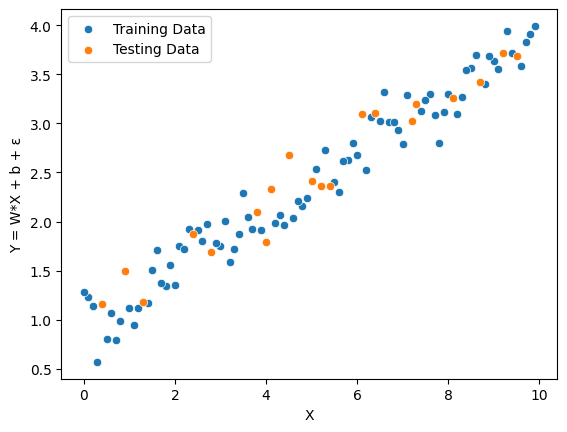

In [5]:
# Plot the training and testing data
def plot_data(X_train, Y_train, X_test, Y_test, Y_pred=None):
    # Squeeze the tensors to remove extra dimensions
    X_train, Y_train = X_train.squeeze(), Y_train.squeeze()
    X_test, Y_test = X_test.squeeze(), Y_test.squeeze()

    sns.scatterplot(x=X_train.cpu(), y=Y_train.cpu(), label="Training Data")
    sns.scatterplot(x=X_test.cpu(), y=Y_test.cpu(), label="Testing Data")

    if Y_pred is not None:
        Y_pred = Y_pred.squeeze()
        sns.scatterplot(x=X_test.cpu(), y=Y_pred.cpu(), label="Predicted Data")
        for x, y, y_pred in zip(X_test.cpu(), Y_test.cpu(), Y_pred.cpu()):
            plt.plot([x, x], [y.item(), y_pred.item()], c="r", linestyle="--")

    plt.xlabel("X")
    plt.ylabel("Y = W*X + b + \u03B5")
    plt.legend()
    plt.show()


plot_data(X_train, Y_train, X_test, Y_test)

## 2. Build a PyTorch model by subclassing `nn.Module`. 
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`. 
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1. 
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [6]:
# Create PyTorch linear regression model by subclassing nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(1, 1)

    def forward(self, X) -> torch.Tensor:
        return self.linear_layer(X)

In [7]:
# Instantiate the model and put it to the target device
model = LinearRegressionModel().to(device)

params = model.state_dict()
for k, v in params.items():
    print(f"{k}: {v}")

linear_layer.weight: tensor([[0.9673]], device='mps:0')
linear_layer.bias: tensor([0.1447], device='mps:0')


## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively. 
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [8]:
# Create the loss function and optimizer
loss_fn = nn.L1Loss()

lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Training loop
def train(epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in tqdm(range(epochs), unit="epoch", desc="Training"):
        model.train()

        Y_train_pred = model(X_train)

        train_loss = loss_fn(Y_train_pred, Y_train)
        train_losses[epoch] = train_loss.item()

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            Y_test_pred = model(X_test)
            test_loss = loss_fn(Y_test_pred, Y_test)
            test_losses[epoch] = test_loss.item()

        if (epoch + 1) % 20 == 0:
            print(
                f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Test loss: {test_loss:.3f}"
            )

    return train_losses, test_losses


# Train model for 300 epochs
epochs = 300
train_losses, test_losses = train(epochs)

Training:   0%|          | 0/300 [00:00<?, ?epoch/s]/Users/adios/Documents/pytorch-course/venv/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:  40%|████      | 121/300 [00:00<00:00, 266.24epoch/s]

Epoch: 19 | Train loss: 0.357 | Test loss: 0.379
Epoch: 39 | Train loss: 0.326 | Test loss: 0.354
Epoch: 59 | Train loss: 0.298 | Test loss: 0.331
Epoch: 79 | Train loss: 0.271 | Test loss: 0.308
Epoch: 99 | Train loss: 0.246 | Test loss: 0.286
Epoch: 119 | Train loss: 0.224 | Test loss: 0.265
Epoch: 139 | Train loss: 0.206 | Test loss: 0.248


Training:  81%|████████▏ | 244/300 [00:00<00:00, 430.62epoch/s]

Epoch: 159 | Train loss: 0.192 | Test loss: 0.232
Epoch: 179 | Train loss: 0.184 | Test loss: 0.220
Epoch: 199 | Train loss: 0.177 | Test loss: 0.211
Epoch: 219 | Train loss: 0.171 | Test loss: 0.200
Epoch: 239 | Train loss: 0.166 | Test loss: 0.194
Epoch: 259 | Train loss: 0.165 | Test loss: 0.188
Epoch: 279 | Train loss: 0.164 | Test loss: 0.184


Training: 100%|██████████| 300/300 [00:00<00:00, 322.57epoch/s]

Epoch: 299 | Train loss: 0.165 | Test loss: 0.183


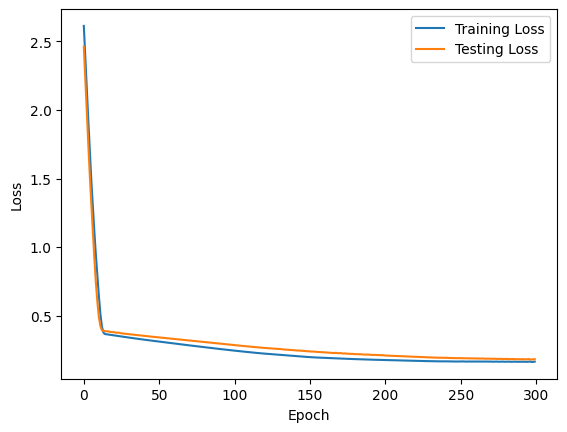

In [10]:
def plot_loss(train_losses, test_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


plot_loss(train_losses, test_losses)

## 4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [11]:
# Make predictions with the model
with torch.inference_mode():
    Y_test_pred = model(X_test)

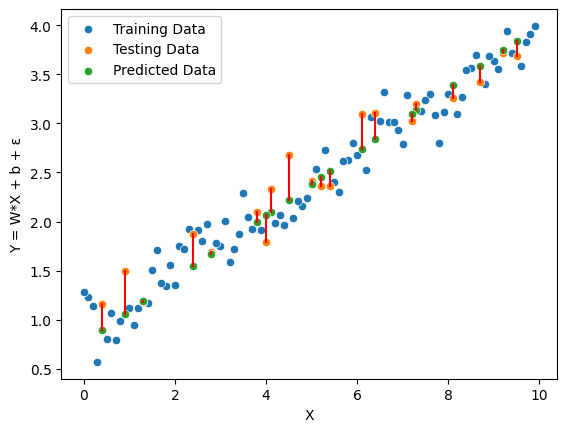

In [12]:
# Plot the predictions (these may need to be on a specific device)
plot_data(X_train, Y_train, X_test, Y_test, Y_test_pred)

## 5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [13]:
from pathlib import Path

# 1. Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)


# 2. Create model save path
save_path = models_dir / "01_ex_linear_regression_model.pt"

# 3. Save the model state dict
torch.save(model.state_dict(), save_path)

In [14]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel().to(device)
loaded_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

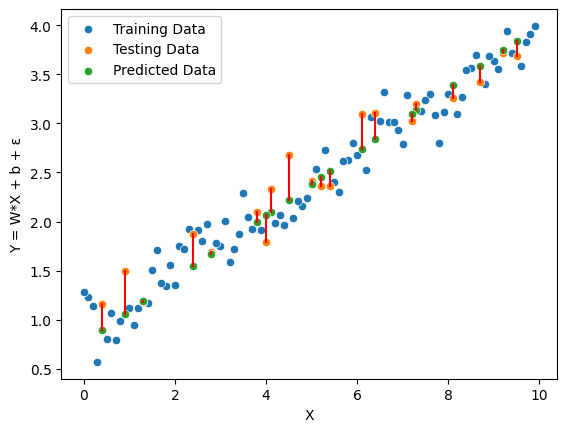

In [15]:
# Make predictions with loaded model and compare them to the previous
with torch.inference_mode():
    Y_test_pred = loaded_model(X_test)
    plot_data(X_train, Y_train, X_test, Y_test, Y_test_pred)